# Intuitions on Convolutions

Let's build some intuitions about these **`convolution operations`**.

🎯 <b><u>Goals</u>:</b>
- **Understand convolution operations**
- **Visualize**
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

🖼 <b><u>Convolutional Neural Networks are Neural Networks specifically designed to work on images</u></b>. 

- 🧮 This is made possible thanks to **`convolution operations`**.

- 🔎 These specific mathematical operations apply a **`filter`** (i.e. a set of **`kernels`**, one per channel) to an input image and create an **`output representation`**. For Convolutional Neural Networks, this can also be called:
    * a **`"convoluted representation/feature"`**,
    * or a **`"convolution"`**,
    * or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/CNN/convolution.png" width="300">

---

❗️ <b><u>Remarks</u></b> ❗️

* It is important to understand that **the same kernel (i.e. the same weights) is applied to different areas of the images**. 

* This is completely different from Dense Neural Networks that we've been working with during the first two units of the Deep Learning module:
    * In `Dense/"Fully Connected" Neural Networks`, each weight of a given neuron is related to only one input coordinate (which, in images, would correspond to one pixel).
    * In `Convolution Neural Networks`, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step"!

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture to understand the whole picture that is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

## (0) The dataset

Let's download the data.

In [1]:
!wget https://wagon-public-datasets.s3.amazonaws.com/06-DL/03-Convolutional-Neural-Networks/deep-learning-circles-triangles/circles-and-triangles.zip
!unzip -qn circles-and-triangles.zip

--2025-04-11 22:58:31--  https://wagon-public-datasets.s3.amazonaws.com/06-DL/03-Convolutional-Neural-Networks/deep-learning-circles-triangles/circles-and-triangles.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.92.2.9, 52.218.117.49, 52.218.28.82, ...
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.92.2.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186323 (182K) [application/zip]
Saving to: ‘circles-and-triangles.zip’

circles-and-triangl 100%[===================>] 181.96K   186KB/s    in 1.0s    

2025-04-11 22:58:39 (186 KB/s) - ‘circles-and-triangles.zip’ saved [186323/186323]



First, let's use the following function `load_data` to... load the data.

* Do not change anything in the function!
* Restrict from any desire to change the shapes or types of the outputs! This will have an impact on further questions.

In [2]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100

    X, y = [], []

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(np.array(Image.open(c_path))[:, :, :1])
        y.append(0)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(np.array(Image.open(t_path))[:, :, :1])
        y.append(1)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

X, y = load_data("data")

❓ **Question about the shape** ❓

* How many images do we have?
* What are their dimensions? 
* Can you comment on the number of channels? 

In [ ]:
# YOUR CODE HERE
print(f"Total number of images: {len(X)}")
print(f"Shape of one image: {X[0].shape}")
print(f"Number of channels: {X[0].shape[-1]}")

Total number of images: 200
Shape of one image: (76, 78, 1)
Number of channels: 1


<details>
    <summary><i>About the number of channels:</i></summary>
   
Actually, we have already talked about this during the `MNIST challenge`.        
        
*  We need only one channel to compute the "*blackness intensity*" of a pixel with 0 corresponding to a black pixel and 1 corresponding to a white pixel. The last dimension corresponds to some kind of  "Black to white channel". 
        
🎨 For colored images, the last dimension would be equal to 3 for `Red, Green, Blue (RGB)`

👉 Have fun playing with the intensities of Red, Green and Blue <a href="https://www.w3schools.com/colors/colors_rgb.asp">`here`</a>
        
        
</details>        

❓ **Question about the normalization** ❓

Do these images need some normalization? 

In [ ]:
# YOUR CODE HERE
# Yes, normalization is generally recommended for neural networks to improve training stability and performance.

<details><summary>Solution</summary>
Yes. We see values of 255. You can easily scale them by dividing X by 255.
</details>

In [ ]:
# YOUR CODE HERE

👀 Let's have a look at some images with `plt.imshow` and show their respective labels.

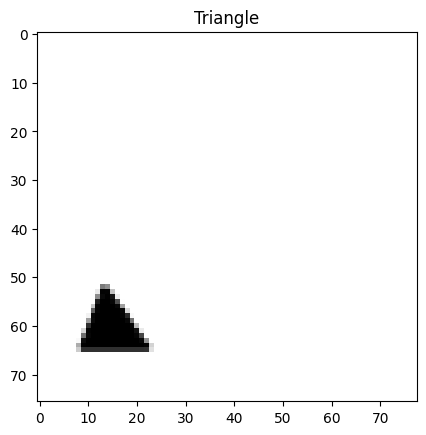

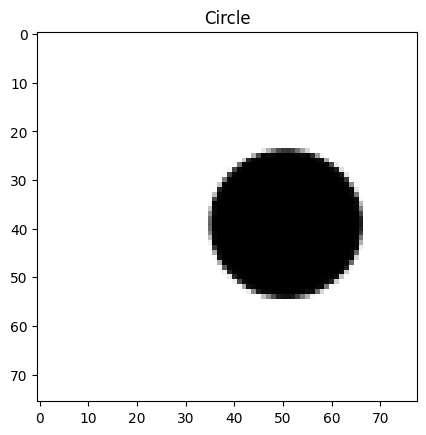

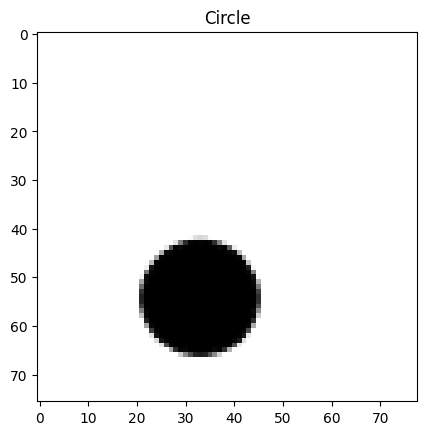

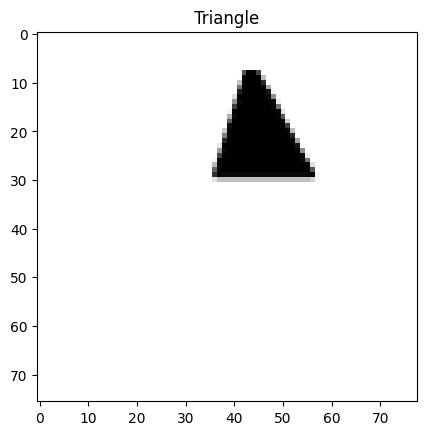

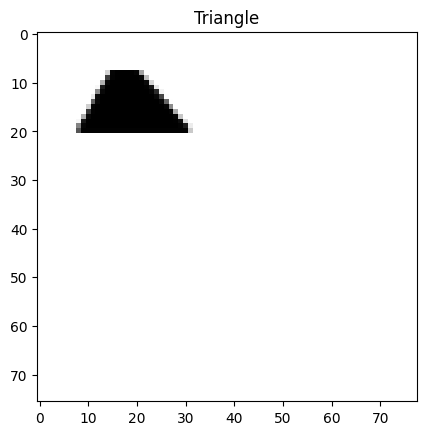

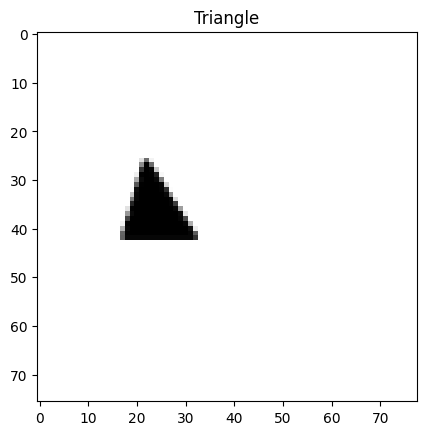

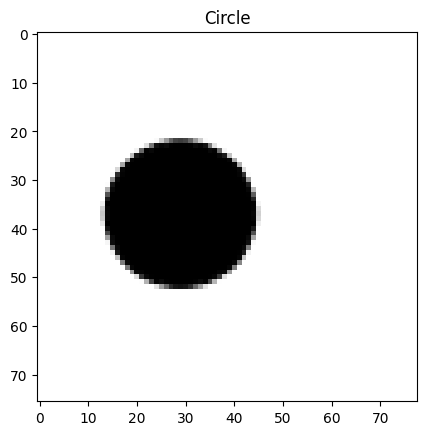

In [6]:
for iter_, (image, label) in enumerate(zip(X, y)):
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Triangle' if label == 1 else 'Circle')
    plt.show()

    if iter_ > 5:
        break

❓ **Question: How many classes are we going to predict** ❓

_This information will help you design the last layer of your Convolutional Network_

In [7]:
# YOUR CODE HERE
# 2 classes: 0 for circles, and 1 for triangles.

## (1) Kernels & Convolutions

🎁 The following function **`compute_convolution`** performs a **convolution operation** $ \Leftrightarrow $ i.e. *it applies a kernel to an image*.

❓ **Question about the `compute_convolution` function** ❓

Run it and try to understand the different steps of this function.

In [8]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1
    img_height, img_width = img.shape

    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []

        for y in range(img_width - kernel_width + 1):

            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())

        output_image.append(arr)

    return output_image

❓ **How does the `compute_convolution` function work in practice** ❓ 

1. Choose any image from the input dataset
2. Apply the `identity_kernel` to it
3. Display both the input image and the output image. 
4. Do you see any differences?

In [9]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

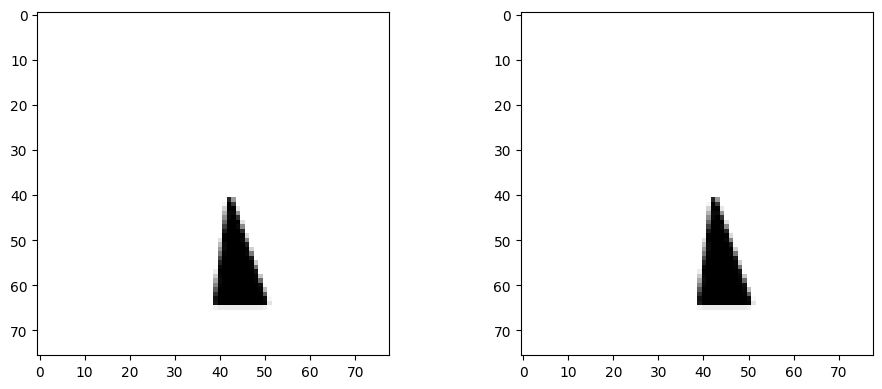

In [ ]:
# YOUR CODE HERE
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def compute_convolution(image, kernel):
    return convolve2d(image.squeeze(), np.array(kernel), mode='same', boundary='fill')

sample_image = X[10]
convolved_image = compute_convolution(sample_image, identity_kernel)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.imshow(convolved_image, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

<details>
    <summary><i>Answer</i></summary>
        
🧑🏻‍🏫 The previous kernel corresponds to the **`identity_kernel`**, meaning that ***the output is equal to the input***... 
    
🕵🏻‍♂️ It basically did nothing to the input image. It you think about it thoroughly, that's not surprising. With this kernel, only the pixel scanned in the middle was kept and multiplied by one, the surrounding pixels were multiplied by zero.        
        
</details>        

🎁 We coded a function **`plot_convolution`** that plots the output image after applying a kernel to an input image.

In [11]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''

    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')

    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')

    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.show()

❓ **Question** ❓ Apply `plot_convolution` with the following `kernel_1` once on an triangle and once on a circle.


In [12]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

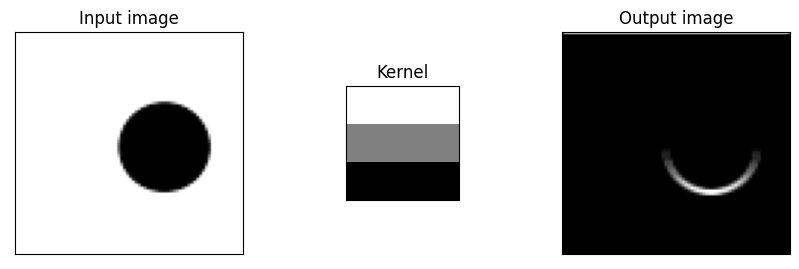

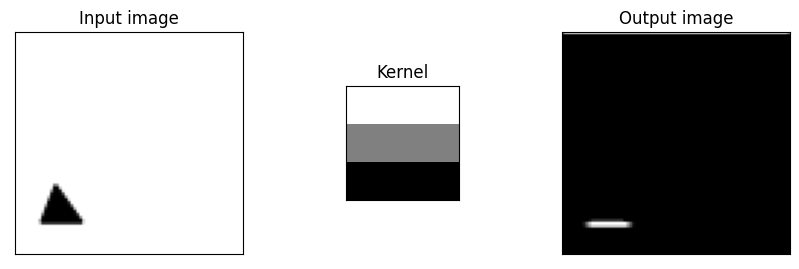

In [ ]:
# YOUR CODE HERE
circle_img = X[y == 0][0]
triangle_img = X[y == 1][0]

plot_convolution(circle_img, kernel_1, activation=True)
plot_convolution(triangle_img, kernel_1, activation=True)

👆 Let's analyze what just happened:

* Black pixels correspond to low values and white pixels to high values:
  * The input image ranges from 0 (shown as black) to 1 (shown as white).
  * The kernels and output images do not range anymore from 0 to 1, but from a negative to a positive number.
  * When they are visualised **black represents the lowest value** (a negative value in this case) **and white the highest value** (a positive value in this case). Anything in between will be a shade of grey.
* In a Neural Network, remember that we use activation functions to remove linearities. 
    * *For example*, when the activation function is `relu`, you already know that it simply corresponds to setting the negative values to 0.

---

❓ **What is the impact of the activation function in a Convolutional Layer ?** ❓

Re-run the previous function `plot_convolution` with `activation` set to `True` (in this case, the activation function is the relu).

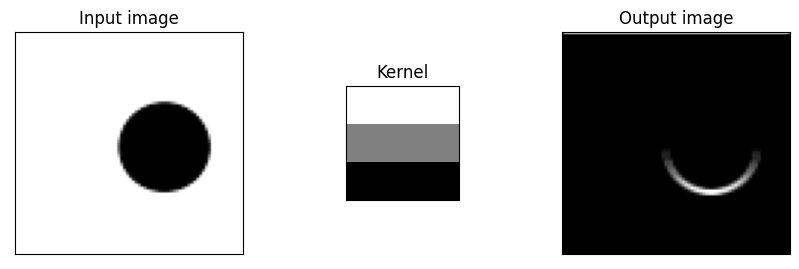

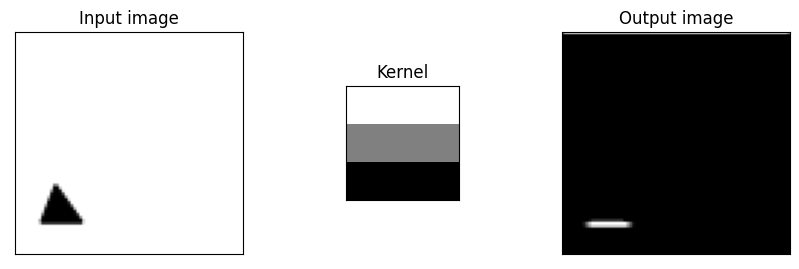

In [14]:
# YOUR CODE HERE
plot_convolution(circle_img, kernel_1, activation=True)
plot_convolution(triangle_img, kernel_1, activation=True)

👆 This kernel is actually highlighting the edges in a given direction. 

❓ **Play with different kernels...** ❓

Try the following kernels to check the different edges they can detect.

In [ ]:

kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

In [22]:
kernels = {
    "Horizontal (Bottom-to-Top)": [
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1]
    ],
    "Vertical (Right-to-Left)": [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ],
    "Vertical (Left-to-Right)": [
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]
    ]
}


Horizontal (Bottom-to-Top) Kernel on CIRCLE:


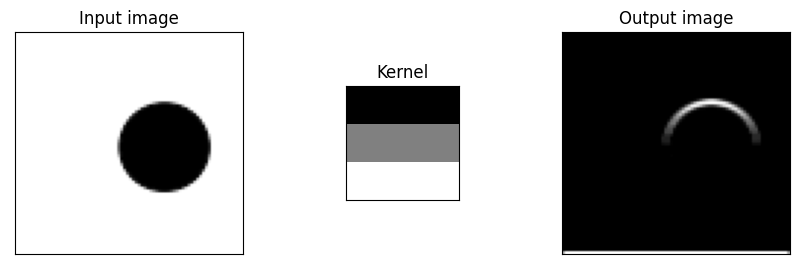


Horizontal (Bottom-to-Top) Kernel on TRIANGLE:


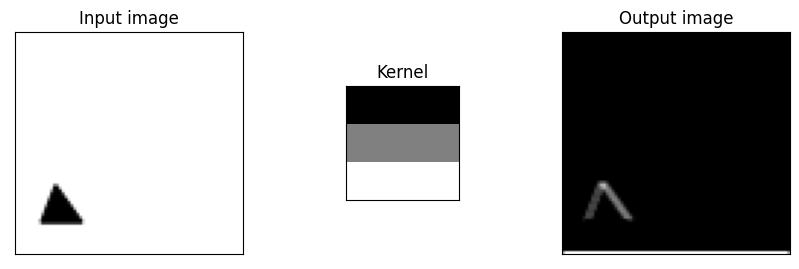


Vertical (Right-to-Left) Kernel on CIRCLE:


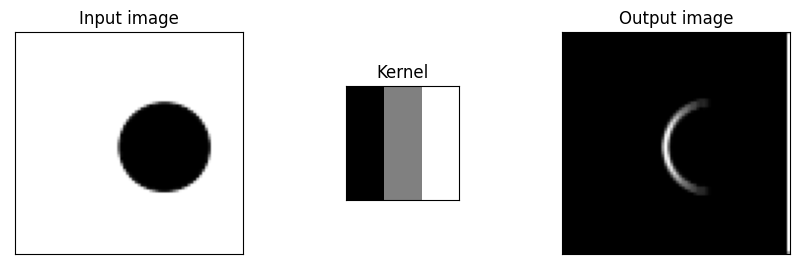


Vertical (Right-to-Left) Kernel on TRIANGLE:


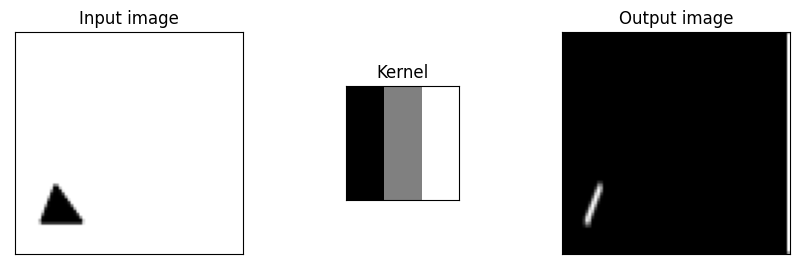


Vertical (Left-to-Right) Kernel on CIRCLE:


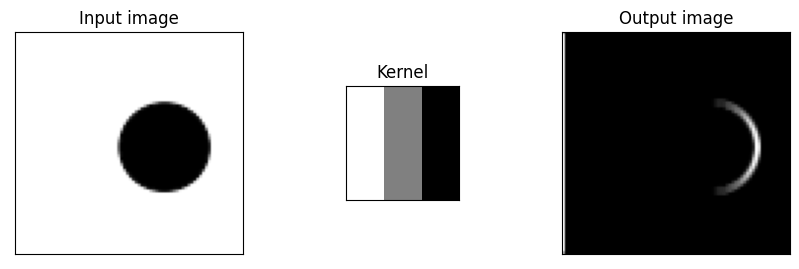


Vertical (Left-to-Right) Kernel on TRIANGLE:


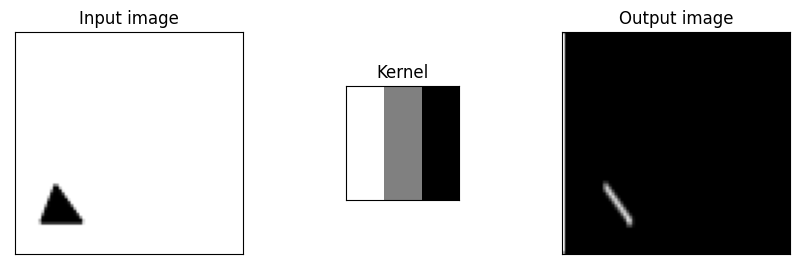

In [ ]:
# YOUR CODE HERE
for name, kernel in kernels.items():
    print(f"\n{name} Kernel on CIRCLE:")
    plot_convolution(circle_img, kernel, activation=True)

    print(f"\n{name} Kernel on TRIANGLE:")
    plot_convolution(triangle_img, kernel, activation=True)

❓ **What is the effect of the kernel size** ❓

Try the _kernel_big_.

In [24]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

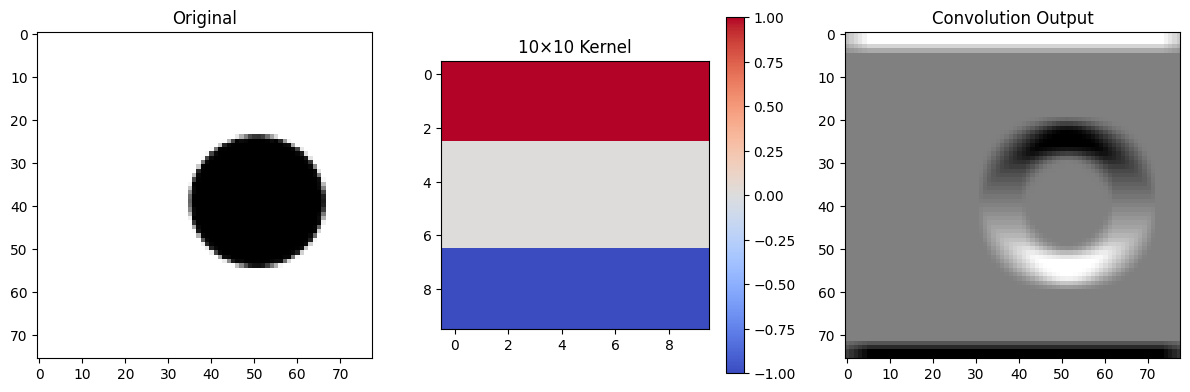

In [26]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(circle_img.squeeze(), cmap='gray')
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(kernel_big, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('10×10 Kernel')
plt.colorbar()

output = convolve2d(circle_img.squeeze(), kernel_big, mode='same')
plt.subplot(1,3,3)
plt.imshow(output, cmap='gray')
plt.title('Convolution Output')

plt.tight_layout()
plt.show()

❓ **Try another kernel**  ❓

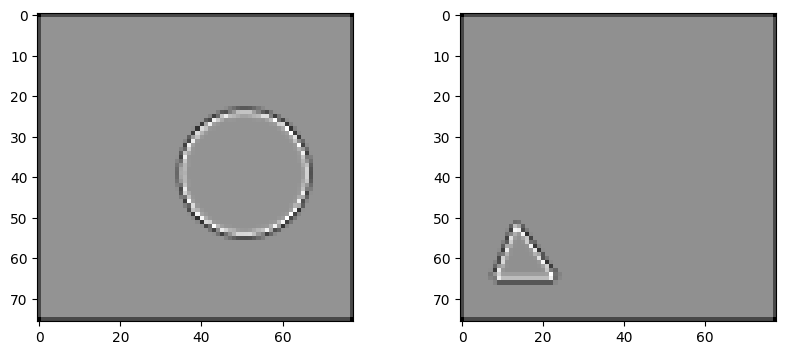

In [28]:
random_kernel = np.random.uniform(-10, 10, (5, 5))
simple_kernel = [
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(convolve2d(circle_img.squeeze(), simple_kernel, mode='same'), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(convolve2d(triangle_img.squeeze(), simple_kernel, mode='same'), cmap='gray')

plt.show()

Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network. ✅

## (2) Training a CNN to detect triangles and circles

### (2.1) Architecture


❓ **Question: Designing a CNN** ❓

Write a Convolutional Network that has 
- a Convolutional Layer with 16 filters with $ (4, 4) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (2, 2) $ kernels.

with:
- A Max-Pooling Layer (with a $ (2, 2) $ pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part 
    - but before the last layer


Also, make sure to compile your model with the appropriate parameters

In [ ]:
from tensorflow.keras import layers, models

def initialize_model():
    model = models.Sequential()

    model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    return model

2025-04-11 23:31:54.261675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### (2.2) Training

❓ **Question: Training the CNN** ❓

* Fit the model. You should achieve a accuracy of *at least* 90%. 

    * When you reach such a high score, it may sound suspicious and you would probably ask yourself whether the model is overfitting or not... but let's ignore it for this challenge 😏

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def initialize_model(input_shape=(28, 28, 1)):
    model = models.Sequential()


    model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = initialize_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 64)        

🎁 We coded the `plot_loss_accuracy` for you.

❓ **Question: does the CNN converge** ❓

_Also, do you see any sign of overfitting?_

In [34]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Resize all images to 28x28
X_resized = np.array([img_to_array(array_to_img(img).resize((28, 28))) for img in X])

# Now split and train
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

model = initialize_model(input_shape=(28, 28, 1))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
4/4 [==============================] - 1s 100ms/step - loss: 4.2437 - accuracy: 0.6016 - val_loss: 2.3966 - val_accuracy: 0.6250
Epoch 2/30
4/4 [==============================] - 0s 18ms/step - loss: 2.2122 - accuracy: 0.5625 - val_loss: 2.0598 - val_accuracy: 0.5938
Epoch 3/30
4/4 [==============================] - 0s 18ms/step - loss: 1.0362 - accuracy: 0.7266 - val_loss: 0.6304 - val_accuracy: 0.6875
Epoch 4/30
4/4 [==============================] - 0s 22ms/step - loss: 0.8051 - accuracy: 0.7656 - val_loss: 0.6699 - val_accuracy: 0.7500
Epoch 5/30
4/4 [==============================] - 0s 17ms/step - loss: 0.4667 - accuracy: 0.8594 - val_loss: 1.0665 - val_accuracy: 0.6875
Epoch 6/30
4/4 [==============================] - 0s 17ms/step - loss: 0.3471 - accuracy: 0.8594 - val_loss: 0.5694 - val_accuracy: 0.6875
Epoch 7/30
4/4 [==============================] - 0s 16ms/step - loss: 0.3525 - accuracy: 0.8203 - val_loss: 0.6229 - val_accuracy: 0.6562
Epoch 8/30
4/4 [==========

In [40]:
# YOUR CODE HERE
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

Epoch 1/30
4/4 [==============================] - 0s 26ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.8438
Epoch 2/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.3274 - val_accuracy: 0.8125
Epoch 3/30
4/4 [==============================] - 0s 16ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.3853 - val_accuracy: 0.8438
Epoch 4/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4088 - val_accuracy: 0.8438
Epoch 5/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.3590 - val_accuracy: 0.8438
Epoch 6/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3254 - val_accuracy: 0.8438
Epoch 7/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3620 - val_accuracy: 0.8438
Epoch 8/30
4/4 [===========

👏 Congratulations! After running a CNN to classify handwritten digits, you were able to design another to classify images either as triangles or circles!

😏 However, you have probably guessed that Computer Vision is obviously more complex than that...

📆 In `Challenge 3 - CIFAR10`, you will try to classify images between 10 categories.

📚 The last section of this notebook will help you build a deeper understanding of CNN. **Read `(2.3) Deeper understanding of CNN` very carefully** before moving on the next challenge!

### 🎁 📚 (2.3) Deeper understanding of CNNs

👩🏻‍🏫 For any Sequential Neural Network (Dense or Convolutional), you can:
- print the **`.summary()`** to display the layers and the number of weights/parameters involved
- access the different **`.layers`** of your model

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 64)        

In [42]:
model.layers

🕵️‍♀️ With the following table, you will have a better overview of the different weights, kernels and filters involved in the CNN you've built earlier:

| layer_number | convolution_layer | kernel_number | channel_number |
|--------------|-------------------|---------------|----------------|
| 0            | conv2D no 1       | 16            | 1              |
| 2            | conv2D no 2       | 32            | 16             |
| 4            | conv2D no 3       | 64            | 32             |
| 6            | conv2D no 4       | 64            | 64             |

#### (2.3.1) Kernels

🧑🏻‍🏫 It is possible to **retrieve the values of all the kernels for each layer after training a CNN**. 

👉 Let's focus first on the different parameters (**`.weights`**) of the first convolutional layer.

In [43]:
# Accessing the first convolutional layer of the CNN
first_convolutional_layer = model.layers[0]
first_convolutional_layer

In [44]:
# Weights of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[0].shape

TensorShape([4, 4, 1, 16])

👆 `TensorShape[4, 4, 1, 16]` represents:
- the weights of each kernel (size `4` $\times$ `4`)
- there was only `1` channel (single B&W input)
- and we have decided to apply `16` different kernels in this layer!

In [45]:
# Biases of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[1].shape

TensorShape([16])

👆 Let's not forget the biases, one per new channel in the output image!

In [46]:
# Notice that we have indeed 256 weights + 16 biases = 272 parameters for the first convolutional layer
4*4*1*16+16

272

> YOUR ANSWER HERE

In [47]:
# Accessing the second convolutional layer of the CNN
second_convolutional_layer = model.layers[2]
second_convolutional_layer

In [48]:
# Weights of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[0].shape

TensorShape([3, 3, 16, 32])

In [49]:
# Biases of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[1].shape

TensorShape([32])

In [50]:
# Notice that we have indeed 4608 weights + 32 biases = 4640 parameters for the third convolutional layer
3*3*16*32+32

4640

In [51]:
# Accessing the third convolutional layer of the CNN
third_convolutional_layer = model.layers[4]
third_convolutional_layer

In [52]:
# Weights of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[0].shape

TensorShape([3, 3, 32, 64])

In [53]:
# Biases of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[1].shape

TensorShape([64])

In [54]:
# Notice that we have indeed 18432 weights + 64 biases = 18496 parameters for the fourth convolutional layer
3*3*32*64+64

18496

In [55]:
# Accessing the fourth convolutional layer of the CNN
fourth_convolutional_layer = model.layers[6]
fourth_convolutional_layer

In [56]:
# Weights of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[0].shape

IndexError: list index out of range

In [57]:
# Biases of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[1].shape

IndexError: list index out of range

In [58]:
# Notice that we have indeed 16384 weights + 64 biases = 16448 parameters for the fourth convolutional layer
(2*2*64+1)*64

16448

🚀 Now that we know how to access the trained weights of each kernel for every convolutional layer, we are going to investigate how they impact the analysis of images.

* 🪄 Using **`plot_convolution(activation = True)`**, let's display the 16 kernels from the first convolutional layer, alongside with the activation output, to see what the model has learned from the images in this layer.

In [ ]:
# YOUR CODE HERE

#### (2.3.2) Activations 🧨

We have been looking at the activation ("_output image_") only after the **first convolutional layer**.

🤔 What if we want to **visualize the activation of an image after every convolutional layer of the CNN** ?

* 📚 We are going to use the [**Functional API**](https://www.tensorflow.org/guide/keras/functional) from Tensorflow/Keras.

* 💪 Stay with us, this is the hardest part of the notebook but also the last one. And we are just asking you to stay focused and read 😉

***Step 0️⃣ : Reminders of the CNN's summary***

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 64)        

***Step 1️⃣: listing all the 11 layers' outputs of your CNN***

In [60]:
layers_outputs = [layer.output for layer in model.layers]
layers_outputs

[<KerasTensor: shape=(None, 25, 25, 16) dtype=float32 (created by layer 'conv2d_11')>,
 <KerasTensor: shape=(None, 12, 12, 16) dtype=float32 (created by layer 'max_pooling2d_9')>,
 <KerasTensor: shape=(None, 10, 10, 32) dtype=float32 (created by layer 'conv2d_12')>,
 <KerasTensor: shape=(None, 5, 5, 32) dtype=float32 (created by layer 'max_pooling2d_10')>,
 <KerasTensor: shape=(None, 3, 3, 64) dtype=float32 (created by layer 'conv2d_13')>,
 <KerasTensor: shape=(None, 1, 1, 64) dtype=float32 (created by layer 'max_pooling2d_11')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'flatten_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>]

***Step 2️⃣ : Instantiate 11 sub-models re-using already trained weights and biases***
- layer1
- layer1 $ \Rightarrow $ layer2
- layer1 $ \Rightarrow $ layer2 $ \Rightarrow $ layer3
- ... 

In [61]:
from tensorflow.keras import Model

activation_models = [Model(inputs=model.input, outputs=output) for output in layers_outputs]

***Step 3️⃣ : Compute the outputs of each submodel***

In [ ]:
activations = [m.predict(X) for m in activation_models]
len(activations)

In [ ]:
[activation.shape for activation in activations]

😎 PRO TIP:
* In Tensorflow, you can also create a single model with many outputs to avoid Python loops / list comprehensions
* Steps 1️⃣ 2️⃣ 3️⃣ can be done as follows:

In [ ]:
layers_outputs = [layer.output for layer in model.layers] # same as above
activation_model = Model(inputs=model.input, outputs=layers_outputs) # model with many outputs !
activations = activation_model.predict(X) # 11 predictions at once!
[activation.shape for activation in activations]

#### (2.3.3) The final show 🥁

🔥 Now that the activations are computed, we can choose one image in the dataset and observe the different "activation images" through each convolutional layer! In other terms, we are now able to observe what the CNN sees for each image! 

* 👇 Run the code down below and observe how a triangle was seen through the different convolutional layers.

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 1)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


* 👇 Run the code down below and observe how a circle) was seen through the different convolutional layers.

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 0)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


🧑🏻‍🏫 ***Notes*** 🧑🏻‍🏫

1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

🕹 Feel free to play with the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) from researchers at [Georgia Tech](https://www.gatech.edu/)

🏁 **Congratulations!**

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!

## (Appendix) Utils

* The following section simply presents the functions that helped us create the dataset with triangles and circles you have been working with.

* They were left at the end of the notebook just in case you want to further prototype and get better understanding of what is going on. 

* But ***for this first day discovering Computer Vision, skip this section and go to the next exercise***, you can always come back to it any time later.

In [67]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)

    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)

def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)

def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()


def create_images(path):
    nb_circles = 100
    nb_triangles = 100

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)